# 半正定値計画問題によるLQR

参考：
* [Reinforcement Learning: Theory and Algorithms](https://rltheorybook.github.io/)

LQRにおいて，リッカチ方程式は半正定値計画問題（SDP）によって解くことができます．
大きな枠組みはMDPにおける線型計画法の扱いと同じです．

今回は無限ホライゾンLQRを考えます．

## 主問題

[前回のLQRの内容](RL_LQR.ipynb)を踏まえると，次のようにして$P$を解くことができます．

$$
\begin{array}{ll}
\operatorname{maximize} & \sigma^2 \operatorname{Trace}(P) \\
\text { subject to } & {\left[\begin{array}{ll}
A^T P A+Q-P & A^{\top} P B \\
B^T P A & B^{\top} P B+R
\end{array}\right] \succeq 0, \quad P \succeq 0,}
\end{array}
$$

**解説**

この形式を導出してみましょう．
MDPにおける線型計画法で使った[Contraction Lemma](RL_as_LP.ipynb)を思い出すと，$P$は次の条件を満たせば良いことがわかります．

$$
A^T P A+Q-A^T P B\left(B^T P B+R\right)^{-1} B^T P A \succeq P .
$$

こｒをSchur complementを使って書き直します．

$$
X=\left[\begin{array}{ll}
D & E \\
E^{\top} & F
\end{array}\right]
$$

とすると，

$$
D-E^{\top} F^{-1} E \succeq 0
$$

は$X$が正定値行列であることの必要十分条件です．

* $E=A^\top P B$
* $F=B^\top P B + R$
* $D = A^T P A+Q-P$

とすると，これが上で定義した制約と同じであることがわかります．

## 双対問題

MDPにおける線型計画法と同様にして，双対問題を考えることができます．

$$
\begin{array}{ll}
\operatorname{minimize} & \operatorname{Trace}\left(\Sigma \cdot\left[\begin{array}{ll}
Q & 0 \\
0 & R
\end{array}\right]\right) \\
\text { subject to } & \Sigma_{x x}=\left(\begin{array}{ll}
A & B
\end{array}\right) \Sigma(A B)^{\top}+\sigma^2 I, \quad \Sigma \succeq 0,
\end{array}
$$

ここで，$\Sigma$は$(d+k)\times (d+k)$の行列であり，

$$
\Sigma=\left[\begin{array}{ll}
\Sigma_{x x} & \Sigma_{x u} \\
\Sigma_{u x} & \Sigma_{u u}
\end{array}\right]
$$

の形式を取ります．これはつまり定常分布の共分散行列を表しており，MDPにおける状態訪問分布と同じような役割を持ちます．

状態数が有限であれば[RL_as_LP.ipynb](RL_as_LP.ipynb)でやったようなアプローチが取れますが，LQRでは状態は$d$次元ベクトルなので，ここでは線形バンディットやLinearMDPにおけるVisitationカウントに近いことをしています．

---

**考察**

多分ですが，
$t$で訪れる状態のベクトルを$x_t$として，

$$\Sigma_{x x} \leftarrow \Sigma_{x x} + x_t x_t^\top$$
みたいな処理をしているかも？（あと初期値として$\sigma^2 I$が足されてる．）
そうすると，$\Sigma_{x x}$のTraceを取ると状態の二乗和が抽出されるので，結局目的関数が元のやつと同じになる？

---


このとき，最適なゲイン行列は

$$
K^{\star}=-\Sigma_{u x}^{\star}\left(\Sigma_{x x}^{\star}\right)^{-1}
$$

で求めることができます．

In [9]:
import numpy as np
from typing import NamedTuple


# 無限ホライゾン用です
class MDP(NamedTuple):
    d: int  # 状態の次元
    k: int  # 入力の次元
    A: np.array  # 遷移行列
    B: np.array  # 遷移行列
    Q: np.array  # コスト行列
    R: np.array  # コスト行列
    sigma: float  # ノイズの大きさ


d = 5
k = 2
sigma = 0.01
A = np.random.randn(d, d) * 0.1
B = np.random.randn(d, k) * 0.1
Q = np.random.randn(d, d)
Q = Q @ Q.T

R = np.random.randn(k, k)
R = R @ R.T

mdp = MDP(d, k, A, B, Q, R, sigma)

In [10]:
# 主問題を説いてみます

import cvxpy as cp

P = cp.Variable((d, d), symmetric=True)

D = mdp.A.T @ P @ mdp.A + mdp.Q - P
E = mdp.A.T @ P @ mdp.B
F = mdp.B.T @ P @ mdp.B + mdp.R

S = cp.bmat([
    [D, E],
    [E.T, F]
])

# 制約を定義します
constraints = [P >> 0, S >> 0]

# 最適化問題を解きます
prob = cp.Problem(cp.Maximize(mdp.sigma ** 2 * cp.trace(P)), constraints)
prob.solve()

P = P.value

In [11]:
import matplotlib.pyplot as plt

# 制御器をダイナミクス上で走らせて得られる価値を観察します
gain = - np.linalg.inv(mdp.B.T @ P @ mdp.B + mdp.R) @ mdp.B.T @ P @ mdp.A
x0 = np.random.randn(mdp.d)
Ptrace = np.trace(P)

Vs = []
for seed in range(10):
    x = x0.copy()
    V = []
    for h in range(100):
        u = - gain @ x

        # コストを計算します
        cost = x.T @ mdp.Q @ x + u.T @ mdp.R @ u
        V.append(cost)

        # ダイナミクスを進めます
        noise = np.random.randn() * mdp.sigma
        x = mdp.A @ x + mdp.B @ u + noise

    cost = x.T @ mdp.Q @ x
    V.append(cost)

    V = np.array(V[::-1])
    V = np.cumsum(V)[::-1]
    Vs.append(V)

mean_V = np.array(Vs).mean(axis=0)
print(f"最後の方の価値：{mean_V[-1]}")
print(f"Pから計算した価値：{mdp.sigma ** 2 * np.trace(P)}")

最後の方の価値：0.0028802448105785337
Pから計算した価値：0.0025237040654423402


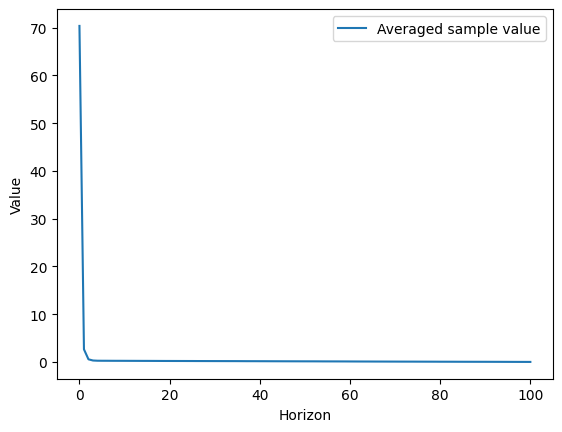

In [12]:

plt.plot(mean_V, label=f"Averaged sample value")
plt.xlabel("Horizon")
plt.ylabel("Value")
plt.legend()

In [13]:
# 双対問題を説いてみます

import cvxpy as cp

Sxx = cp.Variable((d, d), symmetric=True)
Sxu = cp.Variable((d, k))
Suu = cp.Variable((k, k), symmetric=True)

S = cp.bmat([
    [Sxx, Sxu],
    [Sxu.T, Suu]
])

AB = np.block([mdp.A, mdp.B])
QR = np.block([
    [mdp.Q, np.zeros((d, k))],
    [np.zeros((k, d)), mdp.R],
])

constraints = [Sxx == AB @ S @ AB.T + mdp.sigma ** 2 * np.eye(d), S >> 0]

prob = cp.Problem(cp.Minimize(cp.trace(S @ QR)), constraints)
prob.solve()

S = S.value
Sux = Sxu.value.T
Sxx = Sxx.value

In [14]:
import matplotlib.pyplot as plt

# 制御器をダイナミクス上で走らせて得られる価値を観察します
gain = - Sux @ np.linalg.inv(Sxx)
x0 = np.random.randn(mdp.d)

Vs = []
for seed in range(10):
    x = x0.copy()
    V = []
    for h in range(100):
        u = - gain @ x

        # コストを計算します
        cost = x.T @ mdp.Q @ x + u.T @ mdp.R @ u
        V.append(cost)

        # ダイナミクスを進めます
        noise = np.random.randn() * mdp.sigma
        x = mdp.A @ x + mdp.B @ u + noise

    cost = x.T @ mdp.Q @ x
    V.append(cost)

    V = np.array(V[::-1])
    V = np.cumsum(V)[::-1]
    Vs.append(V)

mean_V = np.array(Vs).mean(axis=0)
print(f"最後の方の価値：{mean_V[-1]}")

最後の方の価値：0.0014630946903901405


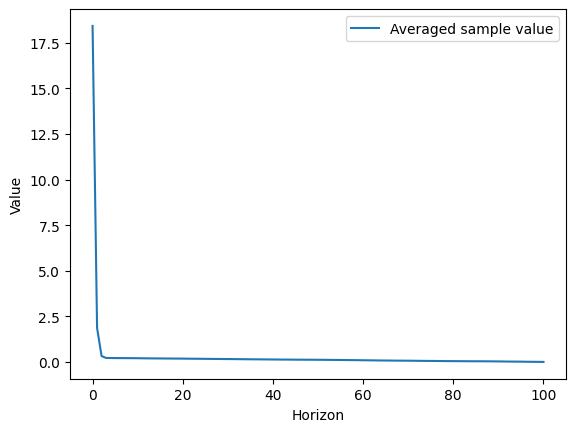

In [15]:

plt.plot(mean_V, label=f"Averaged sample value")
plt.xlabel("Horizon")
plt.ylabel("Value")
plt.legend()